# in this example we will use magpie

In [55]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/training_data_exploded_magpie_featurized.csv')
print(len(df))

28292


In [56]:
# lets see what we're working with. 
# Hypothesis: majority of binaries are unstable. Monoatomics will all be stable. This will create a large class imbalance.
counts = df['stabilityVec'].value_counts()
stable_binaries = df[(df['stabilityVec'] == 1) & (df['FORMULA'].str.contains('\.'))]
unstable_binaries = df[(df['stabilityVec'] == 0) & (df['FORMULA'].str.contains('\.'))]
stable_monatomic = df[(df['stabilityVec'] == 1) & (~df['FORMULA'].str.contains('\.'))]
unstable_monatomic = df[(df['stabilityVec'] == 0) & (~df['FORMULA'].str.contains('\.'))]
print(counts)
print('stable binaries: ', len(stable_binaries))
print('unstable binaries: ', len(unstable_binaries))
print('stable monatomic: ', len(stable_monatomic))
print('unstable monatomic: ', len(unstable_monatomic))

0.0    20655
1.0     7637
Name: stabilityVec, dtype: int64
stable binaries:  2493
unstable binaries:  20655
stable monatomic:  5144
unstable monatomic:  0


In [57]:
# define inputs and outputs: y = label(s), X=features
# https://github.com/hackingmaterials/matminer_examples/blob/master/matminer_examples/machine_learning-nb/bulk_modulus.ipynb
y = df['stabilityVec'].values

excluded = ['Unnamed: 0', 'FORMULA', 'composition', 'stabilityVec']
X = df.drop(excluded, axis=1)

print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

There are 120 possible descriptors:

['MagpieData minimum Number' 'MagpieData maximum Number'
 'MagpieData range Number' 'MagpieData mean Number'
 'MagpieData avg_dev Number' 'MagpieData mode Number'
 'MagpieData minimum MendeleevNumber' 'MagpieData maximum MendeleevNumber'
 'MagpieData range MendeleevNumber' 'MagpieData mean MendeleevNumber'
 'MagpieData avg_dev MendeleevNumber' 'MagpieData mode MendeleevNumber'
 'MagpieData minimum AtomicWeight' 'MagpieData maximum AtomicWeight'
 'MagpieData range AtomicWeight' 'MagpieData mean AtomicWeight'
 'MagpieData avg_dev AtomicWeight' 'MagpieData mode AtomicWeight'
 'MagpieData minimum Column' 'MagpieData maximum Column'
 'MagpieData range Column' 'MagpieData mean Column'
 'MagpieData avg_dev Column' 'MagpieData mode Column'
 'MagpieData minimum Row' 'MagpieData maximum Row' 'MagpieData range Row'
 'MagpieData mean Row' 'MagpieData avg_dev Row' 'MagpieData mode Row'
 'MagpieData minimum CovalentRadius' 'MagpieData maximum CovalentRadius'
 'Ma

In [58]:
# import a random forest algorithm, fit data, make predictions
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
rf = RandomForestClassifier(n_estimators=20, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [59]:
rf_predict = rf.predict(X_test)

In [60]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix

# 10-fold CV (90% = training, 10% = test)
crossvalidation = KFold(n_splits=3, shuffle=False, random_state=1)
rf_cv_score = cross_val_score(rf, X, y, cv=crossvalidation, scoring='roc_auc')

In [61]:
# https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
confusion_matrix = confusion_matrix(y_test, rf_predict)
class_report = classification_report(y_test, rf_predict)
cv_scores = rf_cv_score
avg_auroc = rf_cv_score.mean()

In [62]:
print(cv_scores)
print(avg_auroc)

[0.96082748 0.96762933 0.96143959]
0.9632988014853429


In [ ]:
# method 1: cross-validation
# 1a: test-train split
# 1b: k-fold cv
# method 2: compare against "ground truth" in this case, we will pull in some DFT-predicted stabilities. 

In [63]:
# Great, we have a model trained on our data. let's make some predictions for our training set and test set.
# hypothesis: should have high accuracy for training set and lower for test set.
test_data = 'data/test_data_exploded_magpie_featurized.csv'
df_test = pd.read_csv(test_data)
excluded = ['Unnamed: 0', 'FORMULA', 'composition']
X_test = df_test.drop(excluded, axis=1)
print("There are {} possible descriptors".format(X_test.shape[1]))

There are 120 possible descriptors


In [65]:
print(len(df_test), len(X_test))
df_test['predicted_stabilityVec'] = rf.predict(X_test)
print(df_test['predicted_stabilityVec'].value_counts())
stable_binaries = df_test[(df_test['predicted_stabilityVec'] == 1) & (df_test['FORMULA'].str.contains('\.'))]
print((stable_binaries.head()))
df_test.to_csv('data/test_data_exploded_magpie_featurized_predictions.csv')

8239 8239
0.0    6426
1.0    1813
Name: predicted_stabilityVec, dtype: int64
     Unnamed: 0      FORMULA  composition  MagpieData minimum Number  \
79            7  Ac0.8 Se0.2  Ac0.8 Se0.2                       34.0   
80            7  Ac0.7 Se0.3  Ac0.7 Se0.3                       34.0   
135          12  Mg0.3 Ag0.7  Mg0.3 Ag0.7                       12.0   
137          12  Mg0.5 Ag0.5  Mg0.5 Ag0.5                       12.0   
139          12  Mg0.7 Ag0.3  Mg0.7 Ag0.3                       12.0   

     MagpieData maximum Number  MagpieData range Number  \
79                        89.0                     55.0   
80                        89.0                     55.0   
135                       47.0                     35.0   
137                       47.0                     35.0   
139                       47.0                     35.0   

     MagpieData mean Number  MagpieData avg_dev Number  \
79                     78.0                       17.6   
80                 

In [106]:
# test data
df_test = pd.read_csv('test_data_magpie_featurized.csv')
excluded = ['Unnamed: 0', 'FORMULA', 'composition']
X_test = df_test.drop(excluded, axis=1)
print(len(X.columns), len(X_test.columns))
df_test['predicted_stabilityVec'] = rf.predict(X_test)
df_test = df_test.filter(['FORMULA', 'predicted_stabilityVec'], axis=1)
df_test.to_csv('test_data_predictions.csv')

132 132


In [107]:
print(df_test['predicted_stabilityVec'].value_counts())

0.0    5854
1.0     462
Name: predicted_stabilityVec, dtype: int64


In [73]:
df_equal = df['PROPERTY: stabilityVec'].equals(df['predicted_stabilityVec'])
df['result'] = np.where(df['PROPERTY: stabilityVec'] == df['predicted_stabilityVec'], 'correct', 'incorrect')
print(df['result'].value_counts())

correct      21406
incorrect      165
Name: result, dtype: int64


In [50]:
from sklearn.model_selection import KFold, cross_val_score
crossvalidation = KFold(n_splits=10, shuffle=False, random_state=1)

# compute cross validation scores for random forest model
r2_scores = cross_val_score(rf, X, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 0.983
Folds: 10, mean RMSE: 0.035


In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(rf, X, y, cv=crossvalidation)
confusion_matrix(y, y_pred,)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print(tn, fp, fn, tp)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
F_score = (2 * recall * precision) / (recall + precision)
print(recall, precision, F_score)

18999 0 42 2530
0.9836702954898912 1.0 0.9917679341434731


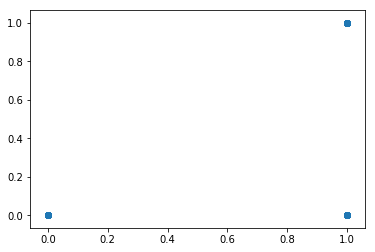

In [54]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred)

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)